In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, GlobalAveragePooling1D
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
from sklearn.random_projection import GaussianRandomProjection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
# some basic HDC operations
# binding: element-wise multiplication
def bind(hv1, hv2):
    return hv1 * hv2

# element-wise addition
def bundle(hv_list):
    bundled = np.zeros(D, dtype=complex)
    for hv in hv_list:
        bundled += hv
    return bundled

# use dot product to test similarity
def similarity(hv1, hv2):
    return np.dot(hv1, hv2) / D

In [ ]:
def gen_basis(n):
  return np.random.choice([-1, 1], size=(D, n))

In [ ]:
# W(D, n) * x(batch_size, n)^T = (D, batch_size)
def encode_feature(x, W):
  projected = np.sign(W @ x.T)  # Binary thresholding to -1 or 1
  return projected.T

In [ ]:
def single_pass_fit(x_train, y_train, W, num_classes):
  class_hvs = np.zeros((num_classes, D), dtype=complex)

  encoded_hvs = encode_feature(x_train, W)

  for c in range(num_classes):
    hv_c = encoded_hvs[y_train == c]
    class_hvs[c] = bundle(hv_c)

  return class_hvs

In [ ]:
# test similarity between the given hypervector and all the classes' hypervector
def predict(x, W, class_hvs):
  hv = encode_feature(x, W)
  sims = [similarity(hv, class_hv) for class_hv in class_hvs]
  # return the class most likely to belong to
  return np.argmax(sims)

In [ ]:
def evaluate_acc(x, y, W, class_hvs):
  correct = 0
  for i in range(x.shape[0]):
    pred_label = predict(x[i], W, class_hvs)
    if pred_label == y[i]:
      correct += 1
  return correct / x.shape[0]

In [ ]:
def iterative_training(x_train, y_train, W, class_hvs, epochs):
  for epoch in range(epochs):
    for i in range(x_train.shape[0]):
      x = x_train[i]
      true_label = y_train[i]
      pred_label = predict(x, W, class_hvs)
      if pred_label != true_label:
        hv = encode_feature(W, x)
        class_hvs[true_label] += hv
        class_hvs[pred_label]  -= hv
  return class_hvs

In [ ]:
!wget -nc https://archive.org/download/food-5-k/Food-5K.zip

--2025-03-15 01:50:54--  https://archive.org/download/food-5-k/Food-5K.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia801606.us.archive.org/13/items/food-5-k/Food-5K.zip [following]
--2025-03-15 01:50:55--  https://ia801606.us.archive.org/13/items/food-5-k/Food-5K.zip
Resolving ia801606.us.archive.org (ia801606.us.archive.org)... 207.241.228.126
Connecting to ia801606.us.archive.org (ia801606.us.archive.org)|207.241.228.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  2.64MB/s    in 76s     

2025-03-15 01:52:11 (5.63 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [ ]:
!unzip -qq -o Food-5K.zip
!mkdir data
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food
!mv Food-5K/training/0*.jpg data/train/nonfood
!mv Food-5K/training/1*.jpg data/train/food
!mv Food-5K/validation/0*.jpg data/test/nonfood
!mv Food-5K/validation/1*.jpg data/test/food

In [ ]:
train_path = 'data/train'
valid_path = 'data/test'

In [ ]:
# check for number of data
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

print(f"len of train image files: {len(image_files)}")
print(f"len of test image files: {len(valid_image_files)}")

len of train image files: 3000
len of test image files: 1000


In [ ]:
# check for number of classes
folders = glob(train_path + '/*')
folders

['data/train/nonfood', 'data/train/food']

In [ ]:
batch_size = 128
K = len(folders) # number of classes
IMAGE_SIZE = [200, 200] # make all images tha same size

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size = IMAGE_SIZE,
    batch_size = batch_size
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    valid_path,
    image_size = IMAGE_SIZE,
    batch_size = batch_size
)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
# check class name
class_names = train_ds.class_names
K = len(class_names)
print(class_names)

['food', 'nonfood']


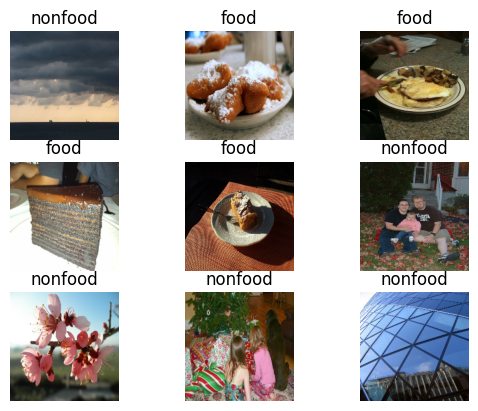

In [ ]:
# visualize the data
for images, labels in train_ds.take(1):
  # takes one batch, but we'll only use 9 (3x3)
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3], # [3] is for the color channel
    weights='imagenet', # download VGG weight trained on imagenet dataset
    include_top=False # incluse_top=False only downloads the convolution part of the model
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# apply preprocess_input
def preprocess(image, label):
  return preprocess_input(image), label

train_ds = train_ds.map(preprocess)
valid_ds = valid_ds.map(preprocess)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
ptm.trainable = False

In [ ]:
x = GlobalAveragePooling2D()(ptm.output)
model = Model(inputs=ptm.input, outputs=x)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 200, 200, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 200, 200, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 100, 100, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 100, 100, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 50, 50, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 50, 50, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 50, 50, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 25, 25, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 25, 25, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 25, 25, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 25, 25, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
x_train = model.predict(train_ds)
x_valid = model.predict(valid_ds)
y_train = np.concatenate([y for x, y in train_ds])
y_valid = np.concatenate([y for x, y in valid_ds])

print(f"x_train.shape: {x_train.shape}, y_train.shape: {y_train.shape}")
print(f"x_valid.shape: {x_train.shape}, y_valid.shape: {y_train.shape}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 653ms/step
x_train.shape: (3000, 512), y_train.shape: (3000,)
x_valid.shape: (3000, 512), y_valid.shape: (3000,)


In [ ]:
x_train.max(), x_train.min()

(206.43527, 0.0)

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)

In [ ]:
TARGET_DIM = 128

# rp = GaussianRandomProjection(n_components=TARGET_DIM)
# x_train_compressed = rp.fit_transform(x_train_scaled)
# x_valid_compressed = rp.transform(x_valid_scaled)
pca = PCA(n_components=TARGET_DIM)
x_train_compressed = pca.fit_transform(x_train_scaled)
x_valid_compressed = pca.transform(x_valid_scaled)

print("Train Compressed Shape:", x_train_compressed.shape)
print("Valid Compressed Shape:", x_valid_compressed.shape)

Train Compressed Shape: (3000, 128)
Valid Compressed Shape: (1000, 128)


In [ ]:
D = 50000
alpha = 2.0
n_features = x_train_compressed.shape[1]
W = gen_basis(n_features)

class_hvs = single_pass_fit(x_train_compressed, y_train, W, K)

acc_train_sp = evaluate_acc(x_train_compressed, y_train, W, class_hvs)
acc_test_sp  = evaluate_acc(x_valid_compressed, y_valid, W, class_hvs)

print(f"Single-pass fit => Train acc:, {acc_train_sp}, Test acc:, {acc_test_sp}")

Single-pass fit => Train acc:, 0.9376666666666666, Test acc:, 0.936


In [ ]:
best_val = 0
best_hvs = class_hvs.copy()
num_epochs = 5
learning_rate = 0.1

for epoch in range(num_epochs):
  class_hvs = iterative_training(x_train_compressed, y_train, W, class_hvs, epochs=1)
  acc_train = evaluate_acc(x_train_compressed, y_train, W, class_hvs)
  acc_test = evaluate_acc(x_valid_compressed, y_valid, W, class_hvs)
  print(f"Epoch {epoch+1}, train={acc_train:.3f}, test={acc_test:.3f}")
  if acc_test > best_val:
    best_val = acc_test
    best_hvs = class_hvs.copy()

acc_test = evaluate_acc(x_valid_compressed, y_valid, W, best_hvs)
print(f"Best val= {best_val: .3f}")

Epoch 1, train=0.953, test=0.949
Epoch 2, train=0.963, test=0.959
Epoch 3, train=0.967, test=0.963
Epoch 4, train=0.971, test=0.968
Epoch 5, train=0.974, test=0.970
Best val=  0.970
